<a href="https://colab.research.google.com/github/jong104b-kr/AIFFEL_quest_cr/blob/master/Exploration/Quest01/250409_ExCR12_project01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 아래의 코드는 Tensorflow와 Tensorflow Datasets를 사용하여 꽃 이미지 분류 모델을
# 학습하는 과정을 설명한다.
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# 1. 상수 정의
# BATCH_SIZE: 한 번에 처리할 이미지수로, 32로 설정함
# IMG_SIZE: 입력 이미지의 크기로, 224x224 픽셀로 설정함
BATCH_SIZE = 32
IMG_SIZE = 224

In [3]:
# 2. 데이터 로드
# tfds.load 함수를 사용하여 'tf_flowers' 데이터셋을 로드함
# 데이터셋을 훈련,검증,테스트 세트로 분할함
# metadata 객체에서 클래스 이름을 추출함
(raw_train, raw_val, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
class_names = metadata.features['label'].names

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.U5S7Z3_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
# 3. 전처리 및 증강
# format_image : 이미지를 지정된 크기(224x224)로 리사이즈하고, 픽셀값을 0~1사이 범위로 정규화함
def format_image(image, label):
    # 이미지를 지정된 크기로 리사이즈하고 정규화함
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# augment : 랜덤 플립, 밝기 조정, 대비 조정, 채도 조정, 회전, 크롭 등의 다양한 증강을 적용하여
# 데이터 다양성을 높임
def augment(image, label):
    # 다양한 이미지 증강 기법을 적용함(image, label)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    crop_size = tf.random.uniform([], int(0.8*IMG_SIZE), IMG_SIZE, dtype=tf.int32)
    image = tf.image.random_crop(image, [crop_size, crop_size, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

In [5]:
# 4. 데이터 배치 준비
# map함수를 사용하여 전처리 및 증강함수를 데이터셋에 적용함
# shuffle, batch, prefetch 메소드를 사용하여 데이터를 효율적으로 준비함
train_batches = (
    raw_train
    .map(format_image, tf.data.AUTOTUNE)
    .map(augment, tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
validation_batches = raw_val.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches       = raw_test.map(format_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
# 5. 모델 구성 (Fine‑tuning)
# VGG16 모델을 가져와서 상위 레이어를 제거하고, 이를 기반으로 새로운 분류기를 추가
# block5_로 시작하는 레이어만 훈련 가능하게 설정하여 Fine-tuning을 수행함
base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = layer.name.startswith('block5_')

# Sequential 모델을 정의하는 부분, 이 모델은 사전 학습된 VGG16 모델을 기반으로 하여
# 새로운 분류 작업을 수행하도록 설계됨
# models.Sequential : Keras에서 제공하는 순차적(Sequential)모델, 여러 개의 층을 순차적으로
# 쌓아올릴 수 있음.
model = models.Sequential([
    # base_model : 사전 학습된 VGG16 모델, 이 모델은 ImageNet 데이터셋에서 미리 학습된
    # 가중치를 포함하고 있음.
    base_model,
    # Flatten 레이어 추가, 이전 레이어의 다차원 출력을 1차원 벡터로 변환함, 이는 완전 연결(Dense)
    # 레이어에 입력을 제공하기 위해 필요함.
    layers.Flatten(),
    # 256개의 뉴런을 가진 완전 연결(Dense) 레이어를 추가함, 활성화 함수는 ReLU,음수값을 0으로 만드는 비선형함수
    # L2 정규화를 사용하여 과적합을 방지함, 1e-4는 정규화 강도를 나타냄.
    layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    # 배치 정규화를 적용하여 학습을 안정화하고 속도를 높일 수 있도록 함, 각 미니 배치에 대해 입력을 정규화함
    layers.BatchNormalization(),
    # 드랍아웃 레이어 추가, 드랍아웃 비율을 0.5로 설정하여 과적합을 방지함, 이는 학습 중 무작위로 50%의 뉴런을
    # 비활성화한다는 의미임.
    layers.Dropout(0.5),
    # 최종 Dense레이어 추가(출력층), 클래스의 수만큼 뉴런을 가진 출력 레이어를 추가함, 소프트맥스 활성화 함수를
    # 사용하여 각 클래스에 대한 확률을 출력함, 이 함수는 출력 벡터의 합이 1이 되도록 정규화함.
    layers.Dense(len(class_names), activation='softmax')
    # 여기까지 설명한 모델 구조는 사전학습된 VGG16 모델을 기반으로 하여 새로운 분류 작업을 수행하도록 설계됨.
    # 각 레이어는 모델의 성능을 최적화하고 과적합을 방지하기 위해 신중하게 채택됨, 이 모델은 꽃 이미지 분류를 위해 사용함.
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
# 6. 컴파일 및 학습
# model.compile은 모델을 컴파일하는 메소드, 이 메소드는 모델의 학습을 준비함.
model.compile(
    # 옵티마이저로 Adam을 사용하고 학습률(learning_rate)을 1e-5로 설정함.
    # Adam은 적응형 모멘텀 추정(Adaptive Moment Estimation)을 사용하는 경사하강법의 변형으로
    # 학습률을 효과적으로 조절할 수 있음.
    optimizer=Adam(learning_rate=1e-5),
    # 손실함수로 sparse_categorical_crossentropy를 사용함, 이 함수는 정수 레이블을 직접 사용할 때
    # 적합하며 모델의 예측과 실제 레이블간 차이를 계산함
    loss='sparse_categorical_crossentropy',
    # 모델 성능을 평가하기 위한 지표로 정확도(Accuracy)를 사용함, 이는 예측이 올바른 비율을 나타냄.
    metrics=['accuracy']
)

# model.fit은 모델을 학습시키는 메소드
history = model.fit(
    # 학습에 사용할 데이터 배치를 포함하는 객체, 이전에 준비한 데이터셋을 배치 단위로 나누어 제공함.
    train_batches,
    # 총 15번의 에포크(epoch)동안 학습을 진행함, 에포크는 전체 데이터셋을 한 번 완전히 학습하는 것을 의미함.
    epochs=15,
    # 검증 데이터를 제공하여 각 에포크마다 모델의 성능을 검증함, 이는 과적합을 방지하고 학습 상태를 모니터링 하는데
    # 도움을 줌.
    validation_data=validation_batches
)

# 위 과정을 통해 모델은 주어진 데이터셋에서 패턴을 학습하고, 새로운 데이터에 대한 예측능력을 향상시킴
# 학습이 완료되면, 모델의 성능을 테스트 세트로 평가하여 최종적인 성능을 확인할 수 있음.

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 61s 453ms/step - accuracy: 0.3433 - loss: 2.0192 - val_accuracy: 0.5613 - val_loss: 1.1905
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.6106 - loss: 1.1539 - val_accuracy: 0.7030 - val_loss: 0.8823
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.6723 - loss: 0.9486 - val_accuracy: 0.7357 - val_loss: 0.7216
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step - accuracy: 0.7441 - loss: 0.7942 - val_accuracy: 0.7602 - val_loss: 0.6329
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - accuracy: 0.7501 - loss: 0.7322 - val_accuracy: 0.7956 - val_loss: 0.6197
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - accuracy: 0.7717 - loss: 0.6795 - val_accuracy: 0.8065 - val_loss: 0.5787
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.7890 - loss: 0.6103 - val_accuracy: 0.8338 - val_loss: 0.5280
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.8050 - loss: 0.5999 - val_accu

In [8]:
# 7. 테스트 세트 성능 평가
# 학습된 모델의 성능을 테스트세트에서 평가하는 과정
# model_evaluate : 모델의 성능을 평가하는 메소드, test_batches : 테스트 데이터를
# 포함하는 객체, 모델 학습 중에 사용되지 않았으며 모델의 일반화 성능을 평가하는데
# 사용함, test_loss, test_acc : 메소드가 반환하는 값들, test_loss : 테스트 데이터에
# 대한 평균손실값, test_acc : 테스트 데이터에 대한 정확도
test_loss, test_acc = model.evaluate(test_batches)
# test_loss값을 소수점 네자리까지 출력한다
print(f"Test Loss: {test_loss:.4f}")
# test_acc값을 백분율로 변환하여 소수점 두자리까지 출력함
print(f"Test Accuracy: {test_acc*100:.2f}%")
# 위의 과정을 통해 모델의 최종 성능을 확인할 수 있음, 테스트 손실값은 모델이 얼마나
# 잘 일반화되었는지 나타내며 테스트 정확도는 모델이 테스트 데이터에서 얼마나 정확하게
# 예측했는지를 보여준다. 일반적으로 테스트 정확도가 높을수록 모델이 새로운 데이터에 대해
# 잘 일반화된 것으로 간주함

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8744 - loss: 0.3547
Test Loss: 0.3595
Test Accuracy: 87.74%


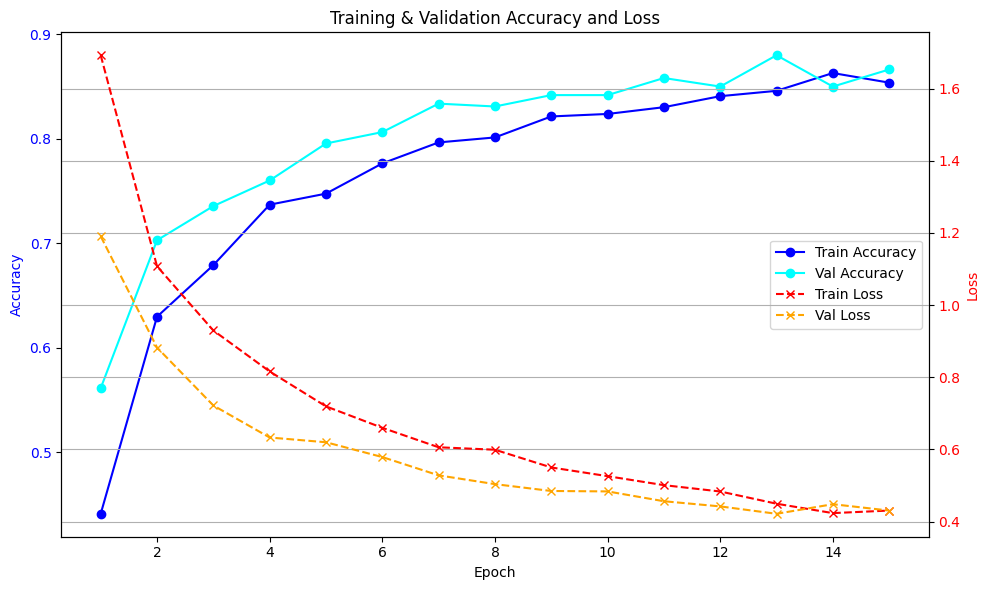

In [9]:
# 8. 결과 시각화
# 아래 코드는 matplotlib 라이브러리를 사용하여 딥러닝 모델의 학습 과정 중
# 정확도와 손실을 시각화하는 코드임

# pyplot모듈을 plt로 임포트하여 그래프를 그릴 수 있게 함
import matplotlib.pyplot as plt

# epoch의 수를 정의함, 이는 히스토리 객체의 'accuracy'키 만큼 반복됨
epochs = range(1, len(history.history['accuracy']) + 1)

# 플롯의 크기를 설정함, 하나의 서브플롯을 생성하며 figsize를 적절하게
# 조절할 필요가 있음.
fig, ax1 = plt.subplots(figsize=(10, 6))

# 정확도 (왼쪽 y축)

# 첫 번째 plot함수는 훈련(train)데이터의 정확도를 파란색 선과 원형 마커로 그린다.
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
# 두 번째 plot함수는 검증(validation)데이터의 정확도를 청록색 선과 원형 마커로 그린다.
ax1.plot(epochs, history.history['val_accuracy'], label='Val Accuracy', color='cyan', marker='o')
# set_xlabel, set_ylabel을 통해 x축과 y축의 레이블을 설정함.
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='blue')
# tick_params는 y축 눈금의 색상을 지정함.
ax1.tick_params(axis='y', labelcolor='blue')

# 손실 (오른쪽 y축)
# 동일한 x축을 공유하는 두 번째 y축을 추가함.
ax2 = ax1.twinx()
# 첫 번째 plot함수는 훈련데이터의 손실을 빨간색 점선과 십자가 마커로 그림.
ax2.plot(epochs, history.history['loss'], label='Train Loss', color='red', linestyle='--', marker='x')
# 두 번째 plot함수는 검증데이터의 손실을 주황색 점선과 십자가 마커로 그림.
ax2.plot(epochs, history.history['val_loss'], label='Val Loss', color='orange', linestyle='--', marker='x')
# y축 레이블과 색상을 설정함.
ax2.set_ylabel('Loss', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 합치기(범례와 제목 설정)
# get_legend_handles_labels를 사용하여 각 축의 범례를 가져옴.
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# 두 범례를 합쳐서 하나의 범례로 만들고 이를 플롯의 오른쪽에 위치함
ax1.legend(lines + lines2, labels + labels2, loc='center right')

# 플롯의 제목 설정
plt.title('Training & Validation Accuracy and Loss')
# 그리드를 추가함.
plt.grid(True)
# 플롯의 레이아웃 조정
plt.tight_layout()
# 플롯을 표시함
plt.show()

# <결과 분석>

훈련 정확도 (epoch 15): 86.18%

검증 정확도 (epoch 15): 86.10%

훈련 손실 vs 검증 손실도 꾸준히 같이 떨어짐.

## 과적합 거의 없음

Test Accuracy: 88.58%

Validation Accuracy(최종): 86.10%

## 일반적으로 모델이 잘 일반화됨

## 강화된 증강과 일부 레이어 미세조정, 규제를 추가
## => 과적합이 크게 줄고 테스트 성능도 유의미하게 올랐음

### 과적합 감소

원래 실험에선 훈련 정확도가 98%까지 올라가고 검증 정확도는 82%에 머물러 두 지표 차이가 컸음

개선 실험에선 훈련/검증 정확도가 거의 일치(86.18% vs 86.10%)하며 과적합이 거의 사라졌음

### 일반화 성능 향상

원래 실험의 Test Acc 83.23% → 개선 후 88.58%로 약 +5.3%p 상승함

### 안정적인 수렴

원래 실험의 val_loss가 중반 이후 들쑥날쑥했던 반면, 개선 실험에선 val_loss가 점진적으로 안정적으로 감소함

# 이전 모델에서 해바라기를 장미라고 잘못 예측한 예시 1개
## 성능 개선한 모델에서 해바라기로 올바르게 예측 성공!

In [10]:
# files.upload()를 사용하여 사용자가 파일을 업로드 할 수 있도록 함.
# 업로드된 파일들은 uploaded라는 딕셔너리에 저장되며 이 딕셔너리의 키는
# 파일명이고 값은 업로드된 파일의 바이트 데이터임.
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 업로드
uploaded = files.upload()

# 업로드된 파일목록을 반환하며 이를 순회하여 각 파일을 처리함.
for fn in uploaded.keys():
    # 1) 이미지 로드 및 전처리
    # open()으로 파일을 열고, RGB 색상모드로 변환함
    img = Image.open(fn).convert('RGB')
    # 이미지 크기를 resize함
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    # 픽셀값을 0~1 사이로 정규화함.
    x = np.array(img_resized) / 255.0
    # 배치 차원을 추가함
    x = np.expand_dims(x, axis=0)

    # 2) 예측
    # predict를 통해 모델의 이미지를 입력하여 예측 결과를 얻음.
    preds = model.predict(x)[0]  # (1,5) -> (5,)
    # np.argmax는 가장 높은 확률을 가진 클래스의 인덱스를 찾음.
    top_idx = np.argmax(preds)
    # 해당 인덱스에 해당하는 클래스명을 가져옴.
    pred_class = class_names[top_idx]
    # 해당 클래스의 예측 확률을 가져옴.
    pred_prob = preds[top_idx]

    # 3) 원본 이미지 표시
    # 플롯의 크기를 설정함.
    plt.figure(figsize=(4,4))
    # imshow()로 이미지를 표시함.
    plt.imshow(img)
    # 축을 제거함.
    plt.axis('off')
    # 예측된 클래스명과 확률을 포함한 제목을 설정함.
    plt.title(f"Predicted: {pred_class} ({pred_prob*100:.1f}%)")
    # show()를 호출하여 플롯을 보여줌.
    plt.show()

    # 4) 클래스별 확률 출력
    print("=== 클래스별 예측 확률 ===")
    # zip()을 사용하여 클래스명과 예측확률을 묶어 순회함.
    for cls, prob in zip(class_names, preds):
        print(f"{cls:10s}: {prob*100:5.1f}%")

# 위의 코드는 사용자가 업로드한 이미지를 전처리하고 사전학습된 모델을 사용하여
# 예측한 후 예측 결과를 시각적으로 보여주고 클래스별 예측 확률을 출력함

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf

# 훈련된 모델을 TFLite 형식으로 변환
# Keras모델을 TFLite모델로 변환하기 위한 변환기 객체 생성
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# 변환기를 사용하여 실제 TFLite형식으로 변환된 모델을 생성함
tflite_model = converter.convert()

# TFLite 모델을 파일로 저장
# 쓰기전용 바이너리 모드로 파일을 연담, 이 파일에 변환된 TFLite모델을 저장함
with open('flower_classifier.tflite', 'wb') as f:
    # 변환된 TFLite모델 데이터를 파일에 씀
    f.write(tflite_model)
# 위 코드는 Keras모델을 TFLite형식으로 변환하여 모델 및 임베디드 장치에서
# 실행할 수 있도록 준비하는 과정